In [1]:
import os
import imp
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import sys
import pickle as plk
import importlib.util
import scipy.optimize

###############################################################
# LINUX PATH

# sys.path.append("/opt/lumerical/v221/api/python") #Default linux lumapi path
# import lumapi
# sys.path.append(os.path.dirname('/home/fotonica04/Documentos/GitHub/Photonics-training/Projects/Hybrid4x4/SimulationFiles')) #Current directory


###############################################################
# WINDOWS PATH

spec_win = importlib.util.spec_from_file_location('lumapi', 'C:\\Program Files\\Lumerical\\v202\\api\\python\\lumapi.py')
lumapi = importlib.util.module_from_spec(spec_win)
os.add_dll_directory("C:/Program Files/Lumerical/v202/api/python")
sys.path.append(os.path.dirname('C:/Users/Caio/Documents/GitHub/Photonics-training/Projects/Hybrid4x4/InterconnectFiles/'))
spec_win.loader.exec_module(lumapi)

## Lumapi init

In [2]:
mmi = lumapi.INTERCONNECT(filename='Hybrid4x4.icp')

## Functions

In [3]:
def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = np.array(tt)
    yy = np.array(yy)
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    guess_freq = abs(ff[np.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = np.std(yy) * 2.**0.5
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):  return A * np.sin(w*t + p) + c
    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*np.pi)
    fitfunc = lambda t: A * np.sin(w*t + p) + c
    #return A
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": np.max(pcov), "rawres": (guess,popt,pcov)}

def linear(t,a,b):
    return a*t + b

In [94]:
Result_IN = mmi.getresult('OSC_1', 'signal')
Result_IP = mmi.getresult('OSC_2', 'signal')
Result_QN = mmi.getresult('OSC_3', 'signal')
Result_QP = mmi.getresult('OSC_4', 'signal')
time = Result_IN['time']
print(Result_IN.keys())

IN_sampled = Result_IN['amplitude (a.u.)']
IP_sampled = Result_IP['amplitude (a.u.)']
QN_sampled = Result_QN['amplitude (a.u.)']
QP_sampled = Result_QP['amplitude (a.u.)']
t = np.ndarray.flatten(time)

IN = np.ndarray.flatten(IN_sampled)
IP = np.ndarray.flatten(IP_sampled)
QN = np.ndarray.flatten(QN_sampled)
QP = np.ndarray.flatten(QP_sampled)
c = 299792458

dict_keys(['time', 'amplitude (a.u.)', 'Lumerical_dataset'])


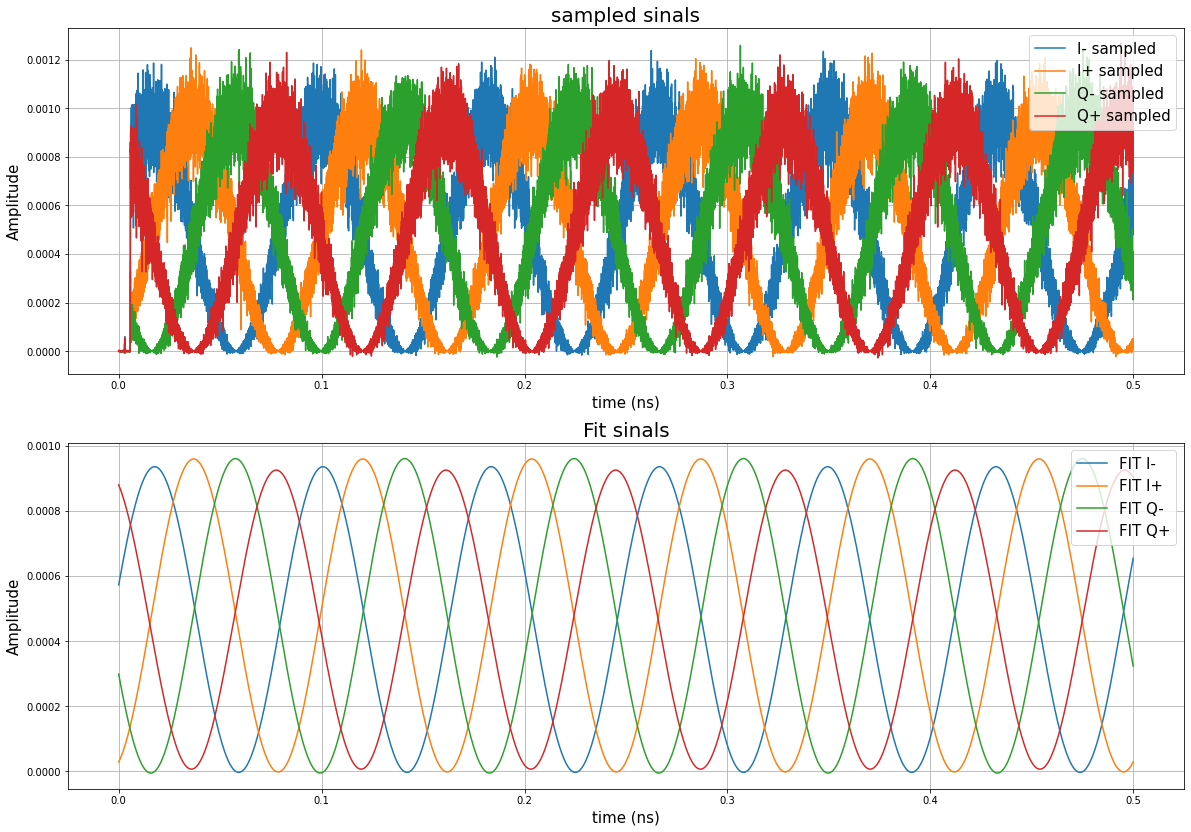

In [95]:
fig, ax= plt.subplots(2,1,figsize=(20,14))
ax[0].plot(time*1e9, IN_sampled, label = 'I- sampled')
ax[0].plot(time*1e9, IP_sampled, label = 'I+ sampled')
ax[0].plot(time*1e9, QN_sampled, label = 'Q- sampled')
ax[0].plot(time*1e9, QP_sampled, label = 'Q+ sampled')
#plt.xlim([0, 1])
ax[0].grid(True)
ax[0].set_xlabel('time (ns)',fontsize =15)
ax[0].set_ylabel('Amplitude',fontsize =15)
ax[0].set_title('sampled sinals',fontsize =20)
ax[0].legend(loc = 'upper right',fontsize =15)

fit_IN = fit_sin(t, IN)
fit_IP = fit_sin(t, IP)
fit_QN = fit_sin(t, QN)
fit_QP = fit_sin(t, QP)

ax[1].plot(time*1e9, fit_IN['amp']*np.sin(2*np.pi*fit_IN['freq']*t+fit_IN['phase'])+fit_IN['offset'], label = 'FIT I-')
ax[1].plot(time*1e9, fit_IP['amp']*np.sin(2*np.pi*fit_IP['freq']*t+fit_IP['phase'])+fit_IP['offset'], label = 'FIT I+')
ax[1].plot(time*1e9, fit_QN['amp']*np.sin(2*np.pi*fit_QN['freq']*t+fit_QN['phase'])+fit_QN['offset'], label = 'FIT Q-')
ax[1].plot(time*1e9, fit_QP['amp']*np.sin(2*np.pi*fit_QP['freq']*t+fit_QP['phase'])+fit_QP['offset'], label = 'FIT Q+')
ax[1].grid(True)
ax[1].set_xlabel('time (ns)',fontsize =15)
ax[1].set_ylabel('Amplitude',fontsize =15)
ax[1].set_title('Fit sinals',fontsize =20)
ax[1].legend(loc = 'upper right',fontsize =15)

In [96]:
print(fit_IN['phase']*180/np.pi)
print(fit_IP['phase']*180/np.pi)
print(fit_QN['phase']*180/np.pi + 180)
print(fit_QP['phase']*180/np.pi)
print('-------')
print(fit_IN['amp'])
print(fit_IP['amp'])
print(fit_QN['amp'])
print(fit_QP['amp'])

13.093801574051918
-69.55515265958181
201.74699049059876
115.68421460272029
-------
0.00046921873352922725
0.0004805173117384171
-0.00048280109685019555
0.0004591172556712665


Text(0, 0.5, 'phase difference (degree)')

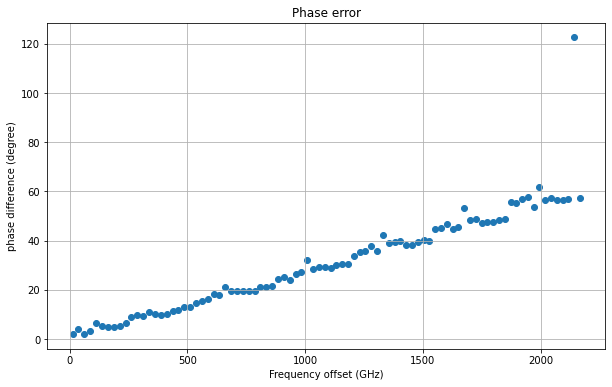

In [102]:
LaserArray = np.arange(1547.6e-9 , 1565e-9, 0.2e-9)
PhaseArray = np.zeros((len(LaserArray)))
FreqArray = abs(c/LaserArray - c/1547.5e-9)

for i in range(len(LaserArray)):
    mmi.switchtodesign()
    mmi.setnamed("CWL_1","frequency",c/LaserArray[i])
    mmi.run()

    Result_IN = mmi.getresult('OSC_1', 'signal')
    Result_IP = mmi.getresult('OSC_2', 'signal')
    Result_QN = mmi.getresult('OSC_3', 'signal')
    Result_QP = mmi.getresult('OSC_4', 'signal')
    time = Result_IN['time']

    IN = np.ndarray.flatten(Result_IN['amplitude (a.u.)'])
    IP = np.ndarray.flatten(Result_IP['amplitude (a.u.)'])
    QN = np.ndarray.flatten(Result_QN['amplitude (a.u.)'])
    QP = np.ndarray.flatten(Result_QP['amplitude (a.u.)'])
    t = np.ndarray.flatten(time)

    fit_IN = fit_sin(t, IN)
    fit_IP = fit_sin(t, IP)
    fit_QN = fit_sin(t, QN)
    fit_QP = fit_sin(t, QP)

    IPhase = fit_IP['phase']*180/np.pi
    QPhase = fit_QN['phase']*180/np.pi

    PhaseArray[i] = abs(90 - abs(QPhase - IPhase))

fig = plt.figure(figsize = (10, 6))
plt.scatter(FreqArray*1e-9,PhaseArray)
plt.grid(True)
plt.title('Phase error')
plt.xlabel('Frequency offset (GHz)')
plt.ylabel('phase difference (degree)')

88
[1.25178956e+10 3.75488342e+10 6.25733049e+10 8.75913101e+10
 1.12602852e+11 1.37607934e+11 1.62606558e+11 1.87598727e+11
 2.12584442e+11 2.37563708e+11 2.62536525e+11 2.87502897e+11
 3.12462826e+11 3.37416314e+11 3.62363365e+11 3.87303980e+11
 4.12238162e+11 4.37165913e+11 4.62087237e+11 4.87002135e+11
 5.11910610e+11 5.36812665e+11 5.61708301e+11 5.86597522e+11
 6.11480330e+11 6.36356727e+11 6.61226716e+11 6.86090300e+11
 7.10947480e+11 7.35798259e+11 7.60642641e+11 7.85480626e+11
 8.10312218e+11 8.35137420e+11 8.59956233e+11 8.84768660e+11
 9.09574703e+11 9.34374366e+11 9.59167650e+11 9.83954558e+11
 1.00873509e+12 1.03350926e+12 1.05827705e+12 1.08303848e+12
 1.10779354e+12 1.13254225e+12 1.15728459e+12 1.18202058e+12
 1.20675021e+12 1.23147350e+12 1.25619043e+12 1.28090102e+12
 1.30560526e+12 1.33030316e+12 1.35499472e+12 1.37967995e+12
 1.40435884e+12 1.42903140e+12 1.45369762e+12 1.47835753e+12
 1.50301110e+12 1.52765836e+12 1.55229929e+12 1.57693391e+12
 1.60156221e+12 1.626

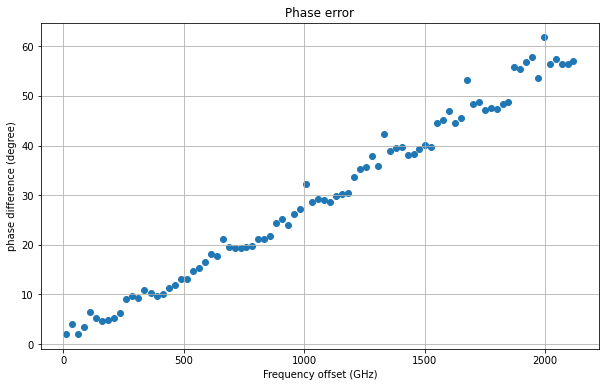

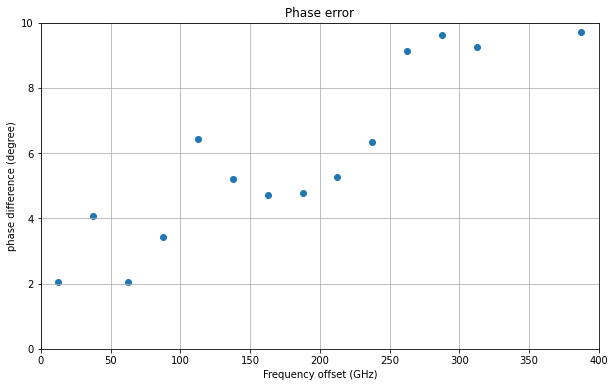

In [113]:
print(len(PhaseArray))

fig = plt.figure(figsize = (10, 6))
plt.scatter(FreqArray[:86]*1e-9,PhaseArray[:86])
plt.grid(True)
plt.title('Phase error')
plt.xlabel('Frequency offset (GHz)')
plt.ylabel('phase difference (degree)')

fig = plt.figure(figsize = (10, 6))
plt.scatter(FreqArray[:86]*1e-9,PhaseArray[:86])
plt.ylim(0,10)
plt.xlim(0,400)
plt.grid(True)
plt.title('Phase error')
plt.xlabel('Frequency offset (GHz)')
plt.ylabel('phase difference (degree)')

print(FreqArray)